In [1]:
#%pip install -U import-ipynb
#%pip install -U parallel-pandas
#%pip install -U mkl_service
#%pip install -U mkl
#%pip install --force-reinstall -v "numpy==1.24.2"
#pip install --force-reinstall -v "MySQL_python==1.2.2"
#%pip install -U openpyxl 


In [2]:
import pandas as pd
import import_ipynb
from psycopg2 import sql
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import itertools
import time
import timeit
from parallel_pandas import ParallelPandas
import os

%load_ext autoreload 
%autoreload 2 
#Custom import
from CallPostgre import Database
import Data_preprocessor  
from ML_models import SupervisedLearning
import Utility_methods as ums

C:\Users\ctmot\.virtualenvs\VirtualEnvs-2crYMRxA\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


importing Jupyter notebook from Data_preprocessor.ipynb
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Connection status: connected

-------------------------------------------------
Successfully connected to the database: homes
-------------------------------------------------
('PostgreSQL 15.4, compiled by Visual C++ build 1914, 64-bit',)
group: ('tenure', 'DEL', 'DEL', 'DEL', 'DEL', 'normal', 0, 1, 0, 1)
Initial dims: X_train: (1512, 27), X_test: (378, 27),y_train: (1512, 1), y_test: (378, 1)
No missing values left. Imputation successful (X)!
No missing values left. Imputation successful (X)!
No missing values left. Imputation successful! (y)

using a method more indicated for normal distributions.
A skewness value of 3.46085 indicates it is a skewed
distribution, better suited for Interquantile Range.
If you're sure you want it treated this way, comment
the '.append()' and 'return' lines.
It will be skipped for this method otherwise.


using a method more indicated for normal distributions.
A skewness value of 0.73085 indicates it is a skewed
distribution, better suited for Interqua

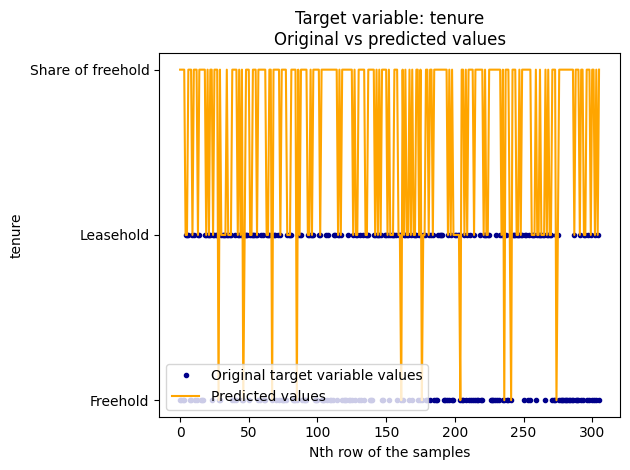

Hits: 103, Misses 203
Perfect prediction_accuracy: 0.3366013071895425
Total run-time for the current build (1 CPU):
1.151715 seconds.
Database connection closed.


In [3]:
# Laptop info for parallelization (performance)
# N_CORES = 6 # 'physical cores'
N_LCORES = os.cpu_count() # "logical" cores (threads * physical cores)
# Values the numpy dtype can hold to prevent overcapping due to
#  transformations the data may suffer during preprocessing
FLOAT32_MAX = 3.402823466 * pow(10, 38)            
FLOAT32_MIN = -FLOAT32_MAX
MAX_NUM_DIGITS_FLOAT32 = 1 + 38

def execute_machine_learning(X_train, X_test, y_train, y_test, scaler_info,
                             ml_algorithm, is_nan_splitting=False):
    regression_model = SupervisedLearning.Regression()
    classification_model = SupervisedLearning.Classification()
    
    y_pred = pd.DataFrame(columns=y_test.columns, index=y_test.index)
    # Features that won't be rounded after scale reversion
    decimal_feature_names = ['coordinate_x', 'coordinate_y'] 

    # Machine learning methods:
    # Regression
    #  1 - Lasso regression
    #  2 - Random Forests (R.)
    #  3 - (Opt.) Multi-layer Perceptron Regressor Neural Network
    # Classification:
    #  'A' - SGD Classifier
    #  'B' - Random Forests (C.)
    #  'C' - (Opt.) Multi-layer Perceptron Classifier Neural Network
    match(ml_algorithm):
        case 1:
            for column_name in y_test.columns:            
                y_pred[column_name] = regression_model.lassoRegression(X_train, X_test, y_train[column_name])            

    
        case 2:
            # RandomForestRegressor '.fit()' and '.predict()' require 'X_train'
            #  and 'X_test' values to be held in numpy's dtype('float32'),
            #  thus they need to be <3.4028235 * 10^38 (approx.)
            if (
                X_train.max()>FLOAT32_MAX or X_test.max()>FLOAT32_MAX or
                X_train.min()<FLOAT32_MIN or X_test.min()<FLOAT32_MIN
            ):
                numeric_bottleneck = max((abs(X_train.max()), abs(X_test.max()),
                                          abs(X_train.min()), abs(X_test.min()))
                                        )
                # Downscale (divide) by the necessary order of magnitude the
                #  exceedingly largest (or smallest) value, so that it is
                #  acceptable by dtype('float32')
                print(f"\nWARNING: Value(s) too large for dtype('float32')"
                      f" detected!\n"
                      f"Downscaling both 'X_train' and 'X_test' until the"
                      f" variable can hold all.")
                print(f"X_train max:\n{X_train.max()}, X_train min:\n{X_train.min()}")
                print(f"X_test max: {X_test.max()}, X_test min: {X_test.min()}")
                num_extra_digits_numeric_bottleneck = ums.get_num_extra_digits_numeric_bottleneck(numeric_bottleneck,
                                                                                                  FLOAT32_MAX)
                # Divide both DataFrames to keep the ratio between the 
                #  "bottleneck" component and the others 
                X_train = X_train / pow(10, num_extra_digits_numeric_bottleneck)
                X_test = X_test / pow(10, num_extra_digits_numeric_bottleneck)
                
            for column_name in y_test.columns:            
                y_pred[column_name] = regression_model.randomForestsRegressor(X_train,
                                                                              X_test,
                                                                              y_train[column_name])
   
    
        case 'A':
            for column_name in y_test.columns:
                y_pred[column_name] = classification_model.stochasticGradientDescentClassifier(X_train,
                                                                                               X_test,
                                                                                               y_train[column_name])

    
        case 'B':
            for column_name in y_test.columns:
                y_pred[column_name] = classification_model.multiLayerPerceptronClassifier(X_train,
                                                                                          X_test,
                                                                                          y_train[column_name])

    
    metrics_results = {'Accuracy' : None, 'Precision' : None, 'Recall' : None,
                      'RMSE' : None, 'MAE' : None, 'MAPE' : None, 
                      'Accuracy_perfect' : None, 'Avg_error_margin' : None}
    
    # Revert scale #
    #
    #* If it's not a text (categorical) target variable
    if (scaler_info[0] is not None): #*
        #* If the chosen scaler was...none, no revertion would be needed
        if (scaler_info[0]!='No scaler'): #*
            y_test = ums.revert_scale(y_test, scaler_info, y_test)
            #* Ensure it's a regressor
            if isinstance(ml_algorithm, int): #* 
                y_pred = ums.revert_scale(y_pred[column_name], scaler_info, y_test)
                # Revertion from Power_Transformer may result in NaN's 
                # To avoid errors in the metrics due to this, remove them
                for column_name in y_pred.columns:
                    if y_pred[column_name].isna().sum()>0:
                        # Indexes as shown in the DataFrame/Series 
                        shown_indexes_to_drop = y_pred[y_pred[column_name].isna()==True].index.to_list()
                        # Indexes as in the order in the DataFrame/Series 
                        #  (since X_test is a np.ndarray)
                        order_indexes_to_drop = []
                        for shown_index_to_drop in shown_indexes_to_drop:
                            order_indexes_to_drop.append(y_pred.index.get_loc(shown_index_to_drop))
                        y_test.drop(index=shown_indexes_to_drop, inplace=True)
                        y_pred.drop(index=shown_indexes_to_drop, inplace=True)
                        X_test = np.delete(X_test, order_indexes_to_drop, axis=0)

        # To understand the practical meaning of some metrics
        print(f"y_test min:{y_test.min()}") 
        print(f"y_test max:{y_test.max()}")
        # Keep the exact prediction value to calculate the error margin
        exact_y_pred = y_pred.copy(deep=True)  
        for column_name in y_test.columns:            
            if column_name not in decimal_feature_names:
                #* Comment if the exact prediction value matters
                y_pred[column_name] = y_pred[column_name].round(decimals=0) #*
                # Rounding for 'y_test' also necesary due to very small errors
                #  in numerical precision during the reversion, resulting in
                #  numbers like 3.0000000000000004 if not addressed
                y_test[column_name] = y_test[column_name].round(decimals=0) 
                
            elif column_name in ['coordinate_x', 'coordinate_y']:
                # Comment if the exact prediction value matters
                y_pred[column_name] = y_pred[column_name].round(decimals=2) #*
                y_test[column_name] = y_test[column_name].round(decimals=2)
        
        # Metrics (for regressors)
        if is_nan_splitting == False:
            
            r_metric_rmse = metrics.root_mean_squared_error(y_test, y_pred)
            print(f"RMSE: {r_metric_rmse}")
            r_metric_mae = metrics.mean_absolute_error(y_test, y_pred)
            print(f"MAE: {r_metric_mae}")
            r_metric_mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
            r_metric_mape_percent = round(r_metric_mape*100, 2)
            print(f"MAPE: {r_metric_mape_percent}")
            r_metric_accuracy_percent = round((1-r_metric_mape)*100, 2)
            print(f"Accuracy: {r_metric_accuracy_percent}%")
            # Save on file
            metrics_results['RMSE'] = round(r_metric_rmse, 5)
            metrics_results['MAE'] = round(r_metric_mae, 5)
            metrics_results['MAPE'] = r_metric_mape_percent
            metrics_results['Accuracy'] = r_metric_accuracy_percent


    # If it's a categorical target variable
    elif isinstance(ml_algorithm, str):
        # Metrics (for classifiers)
        if is_nan_splitting == False:
            # Precision
            c_metric_precision = metrics.precision_score(y_test, y_pred,
                                                         average=None,
                                                         zero_division=np.nan)
            print(f"Precision (tp/(tp+fp)) {c_metric_precision}")
            # Recall
            c_metric_recall = metrics.recall_score(y_test, y_pred, 
                                                   average=None,
                                                   zero_division=np.nan)
            print(f"Recall (tp(tp+fn)) {c_metric_recall}")
            # Accuracy
            c_metric_accuracy_percent = round(metrics.accuracy_score(y_test, y_pred)*100,
                                              2) 
            print(f"Accuracy {c_metric_accuracy_percent}%")
            
            # Save on file
            metrics_results['Precision'] = np.round(c_metric_precision, 5)
            metrics_results['Recall'] = np.round(c_metric_recall, 5)
            metrics_results['Accuracy'] = np.round(c_metric_accuracy_percent, 5)


    # Plot #
    if is_nan_splitting == False:
        for column_name in y_test.columns:
            # Plot target variable vs prediction results
            plt.title(f"Target variable: {column_name}\nOriginal vs predicted values")
            plt.plot(np.arange(0, X_test.shape[0]), y_test[column_name], '.', 
                     label='Original target variable values', color='darkblue')
            plt.plot(np.arange(0, X_test.shape[0]), y_pred[column_name],
                     label='Predicted values', color='orange')
            plt.xlabel('Nth row of the samples')
            plt.ylabel(f"{column_name}")
            plt.legend(loc='best')
            plt.tight_layout()
            # Note: edit, for multi-target prediction
            plt.savefig(f"Predictions_vs_true_values_{y_test.columns[0]}") #* 
            plt.show()
            
            # Get prediction accuracy #
            prediction_keywords = ['Hit','Miss']
            prediction_assessment = pd.concat([y_test[column_name], y_pred[column_name]], 
                                              axis=1)
            # Rename the 'y_test' and 'y_pred' columns so they don't have the
            #  same name
            prediction_assessment.columns = ['original_'+column_name, 'predicted_'+column_name] 
            conditions = [y_pred[column_name] == y_test[column_name]]
            choice_list = [prediction_keywords[0]]
            prediction_assessment['verdict'] = np.select(conditions, choice_list, 
                                                         default=[prediction_keywords[1]])
            
            if prediction_assessment['verdict'].value_counts().shape[0] == 2: 
                prediction_hits = prediction_assessment['verdict'].value_counts().loc[prediction_keywords[0]]
            else: # Means it only registered misses
                prediction_hits = 0
            prediction_misses = prediction_assessment['verdict'].value_counts().loc[prediction_keywords[1]]
            print(f"Hits: {prediction_hits}, Misses {prediction_misses}")
            perfect_prediction_accuracy = prediction_hits / (prediction_misses + prediction_hits) 
            print(f"Perfect prediction_accuracy: {perfect_prediction_accuracy}")
            metrics_results['Accuracy_perfect'] = round(perfect_prediction_accuracy, 5)
                
    return y_pred, metrics_results

###################################################
###################################################

db = Database() 

#############################################
# Data preprocessing 
#  - Type corrections,
#  - Integration (merging table dfs into one
#  - Train/test split,
#  - Handling missing data
#  - Handling outliers
#  - Encoding categoricals
#  - Scaling values
#  - Dimensionally reduce the dataset
#############################################
table_names = ["real_estate_agent", "home_liverpool"]
tables_as_dfs = [] # Dataframes corresponding to the tables, which will be merged
filled_tables_as_dfs = [] # A copy, for the (missing) data filled with predictions
for table_name in table_names:

    # Select all table's data
    query = sql.SQL("""
        SELECT *
        FROM {}
    """).format(sql.Identifier(table_name))
    db.cursor.execute(query)

    # Dynamically get the column names from the db (to also copy onto the df)
    column_names = [description[0] for description in Database.cursor.description]

    # Store data as dataframe (give the same column names as in the db for
    #  simplicity)   
    table_as_df = db.postgresql_to_dataframe(query, column_names)

    # Add it to the list to merge into the full dataset.
    tables_as_dfs.append(table_as_df)
    filled_tables_as_dfs.append(table_as_df.copy(deep=True))



########################
########################
# Predict missing data #
########################
########################

ParallelPandas.initialize(n_cpu=None, split_factor=1, show_vmem=False,
                           disable_pr_bar=True)            

# ONLY FOR A "ONE-OFF" CASE (to run a specific set up)
# Overrides the `available_settings_options in Utility_methods.py`
preprocessing_settings = {            
            'target_variable_name' : 'tenure', 
            #* For selecting which variables will (not) be filled
            'missing_data_threshold' : 0.5, #* 
            'features_to_drop_expert_knowledge': {'photos', 'feature_set',
                                                  'description', 
                                                  'home_liverpool_id', 
                                                  'listing_date_year'}, #* 
            # If true, split train/test data based on the Nan's (for filling 
            #  missing data with predictions). Rows where the target is NaN
            #  become the test set, the rest is put in the training one 
            'is_nan_splitting' : False, 
            # For imputing missing data 
            'numeric_imputation_method_X' : 2, 
            'categorical_imputation_method_X' : 'A',
            'numeric_imputation_method_y' : 1,
            'categorical_imputation_method_y' : 'DEL',
            # For handling outliers
            'distribution_type' : 'normal', 
            'outlier_treating_method' : 2,
            # For encoding the categorical variables
            'encoding_method' : 3,
            # For feature scaling
            'scaling_method' : 2, 
            # For dimensionality reduction and feature selection
            'dimensionality_reduction_method' : 3
} 
# IF NOT EQUAL TO 'PREVIOUS' it will get the option  from
#  ums.choose_ml_algorithm(...)           }
ml_settings = {'ml_algorithm' : [2, 'A']} 

 
#* For selecting which variables will (not) be filled
missing_data_threshold = preprocessing_settings['missing_data_threshold']
features_to_drop_expert_knowledge = preprocessing_settings['features_to_drop_expert_knowledge']

# If true, split train/test data based on the Nan's (for filling missing data
#  with predictions). Rows where the target is NaN become the test set, the 
#  rest is put in the training one
is_nan_splitting = preprocessing_settings['is_nan_splitting'] 

# For imputing missing data
numeric_imputation_method_X = preprocessing_settings['numeric_imputation_method_X']
categorical_imputation_method_X = preprocessing_settings['categorical_imputation_method_X'] 
numeric_imputation_method_y = preprocessing_settings['numeric_imputation_method_y'] 
categorical_imputation_method_y = preprocessing_settings['categorical_imputation_method_y'] 

# For handling outliers
distribution_type = preprocessing_settings['distribution_type']
outlier_treating_method = preprocessing_settings['outlier_treating_method']

# For encoding the categorical variables
encoding_method = preprocessing_settings['encoding_method']

# For feature scaling
scaling_method = preprocessing_settings['scaling_method']

# For dimensionality reduction and feature selection
dimensionality_reduction_method = preprocessing_settings['dimensionality_reduction_method']


##############################################################
# Run ALL preprocessing and ml algorith grouping possibilities
#  to find the  one with the best performance (accuracy)
##############################################################
# Get all preprocessing/ml options
target_variable_names, numeric_imputation_methods_X, \
                            categorical_imputation_methods_X, \
                            numeric_imputation_methods_y, \
                            categorical_imputation_methods_y, \
                            distribution_types, \
                            outlier_treating_methods, \
                            encoding_methods, \
                            scaling_methods, \
                            dimensionality_reduction_methods, \
                            ml_algorithms = ums.get_available_settings_options()

# Get results for all grouping possibilities #

i=0
# To avoid (re)choosing the ml algorithm if the t.var. is the same
target_variable_name_previous='_' 
time_start = time.time()
for group in itertools.product(target_variable_names, numeric_imputation_methods_X, 
                               categorical_imputation_methods_X, numeric_imputation_methods_y, 
                               categorical_imputation_methods_y, distribution_types,
                               outlier_treating_methods, encoding_methods,
                               scaling_methods, dimensionality_reduction_methods):

    print(f"group: {group}")
    # Store current settings in a dictionary (not necessary but adds transparency)
    # Pass current 'preprocessing_settings' to kepp any "static" values such as
    # 'target_variable'
    #preprocessing_settings = ums.group_to_dictionary(group, preprocessing_settings)
 
    
    # Preprocess the data in the dataframes/datasets
    X_train, X_test, y_train, y_test, scaler_info = Data_preprocessor.preprocess_dataframes_data(tables_as_dfs, preprocessing_settings)
    
    # Some configurations are not possible (ex: LDA can only be used with text
    #  target variables and not numeric). 
    #  On those cases, 'X_train' (/'X_test') or 'y_train' (/'y_test') would return 'N/A'.
    #  Thus, they are of no value and can be skipped.
    if (
        type(X_train) is str or type(X_test) is str or
        type(y_train) is str or type(y_test) is str
    ):
        print(f"This specific settings grouping {group}"
              f"was unable to work together during the "
              f"DATA PREPROCESSING stage.")
        print(f"\"Continuing\" (skipping) the group.")
        continue

    
    target_variable_name = preprocessing_settings['target_variable_name']

    # Choose,if necessary and based on 'target_variable' type,
    #  which algorithm to keep  (Reg. or Cla.) 
    key_ml_algorithm = 'ml_algorithm'
    #* If the target variable didn't change, no need to (re)choose between 
    #   Reg. or Cla. algorithms
    if target_variable_name == target_variable_name_previous: #*
        ml_algorithm = ml_settings[key_ml_algorithm]
    else:
        ml_algorithm = ums.choose_ml_algorithm(y_train, ml_algorithms)   
        ml_settings[key_ml_algorithm] = ml_algorithm
        target_variable_name_previous = target_variable_name
         
    

    # Do the test predictions with the machine learning models
    y_pred, metrics_results = execute_machine_learning(X_train, X_test, y_train,
                                                       y_test, scaler_info,
                                                       ml_algorithm)
    if type(y_pred) is str:
        print(f"This specific settings grouping {group}"
              f"was unable to work together during the"
              f"MACHINE LEARNING (model + predictions) stage.")
        print(f"\"Continuing\" (skipping) the group.")
        continue

    # Save the settings and corresponding (metric) results in the 
    #  "performance_results_<targetvarname>_<mlalgorithmused>" csv file 
    ums.file_append_metrics_and_settings(preprocessing_settings, ml_settings,
                                         metrics_results)
    

    i+=1 
    if i==1:  
        break 

time_end = time.time()
print(f"Total run-time for the current build (1 CPU):\n"
      f"{(time_end - time_start):.6f} seconds.")



db.disconnect()



In [4]:
db.disconnect()


Database connection closed.
